## Data Loading & Preprocessing

In [1]:
# -------------------------------
# 1. Import Libraries
# -------------------------------
import os
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# -------------------------------
# 2. Set Root Path
# -------------------------------
root_path = "C:/Users/ELITEBOOK/Downloads/MobiFall_Dataset_v2.0/sub10"

# Check sub10 contents
print("sub10 folders:", os.listdir(root_path))

# -------------------------------
# 3. Define Desired Activities
# -------------------------------
activities = {
    "STD": "Standing",
    "SCH": "Sitting",
    "WAL": "Walking",
    "BSC": "Back_Sitting_Chair",
    "FOL": "Fall_Forward_Lying",
    "SDL": "Sideward_Lying"
}

parent_map = {
    "ADL": ["STD", "SCH", "WAL"],
    "FALLS": ["BSC", "FOL", "SDL"]
}

# -------------------------------
# 4. Function to Read MobiFall File
# -------------------------------
def read_mobifall_file(file_path):
    # Find the line number where @DATA is
    with open(file_path, 'r') as f:
        for i, line in enumerate(f):
            if line.strip() == "@DATA":
                start_row = i + 1
                break
    
    # Read data starting after @DATA
    df = pd.read_csv(file_path,
                     sep=",",
                     header=None,
                     skiprows=start_row,
                     engine="python")
    
    # Determine number of columns
    if df.shape[1] == 4:
        df.columns = ["timestamp_ns", "accX", "accY", "accZ"]
    elif df.shape[1] == 7:
        df.columns = ["timestamp_ns", "accX", "accY", "accZ", "gyroX", "gyroY", "gyroZ"]
    else:
        raise ValueError(f"Unexpected number of columns in file {file_path}: {df.shape[1]}")
    
    # Convert timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp_ns'], unit='ns')
    
    return df

# -------------------------------
# 5. Load All Files Dynamically
# -------------------------------
data_list = []

for parent_folder, subfolders in parent_map.items():
    for subfolder in subfolders:
        folder_path = os.path.join(root_path, parent_folder, subfolder)
        if not os.path.exists(folder_path):
            print("Folder not found:", folder_path)
            continue
        
        for file in os.listdir(folder_path):
            if file.endswith(".txt"):
                file_path = os.path.join(folder_path, file)
                df = read_mobifall_file(file_path)
                df['label'] = activities[subfolder]
                df['file'] = file
                data_list.append(df)

# Combine all data
data = pd.concat(data_list, ignore_index=True)
print("Data loaded. Shape:", data.shape)
print("Labels:", data['label'].unique())

# -------------------------------
# 6. Timestamp Handling
# -------------------------------
data = data.sort_values(by='timestamp').reset_index(drop=True)

# -------------------------------
# 7. Handle Missing Values
# -------------------------------
data = data.ffill()

# -------------------------------
# 8. Remove Duplicates
# -------------------------------
data = data.drop_duplicates()

# -------------------------------
# 9. Summary
# -------------------------------
print("Final Data Shape:", data.shape)
print("\nLabels Distribution:\n", data['label'].value_counts())
data.head()

# -------------------------------



sub10 folders: ['ADL', 'FALLS']
Data loaded. Shape: (355313, 7)
Labels: ['Standing' 'Sitting' 'Walking' 'Back_Sitting_Chair' 'Fall_Forward_Lying'
 'Sideward_Lying']
Final Data Shape: (355313, 7)

Labels Distribution:
 label
Walking               148408
Standing              145934
Sitting                17466
Sideward_Lying         14538
Back_Sitting_Chair     14521
Fall_Forward_Lying     14446
Name: count, dtype: int64


,timestamp_ns,accX,accY,accZ,timestamp,label,file
0,750563025000,4.218941,-4.139223,9.667248,1970-01-01 00:12:30.563025,Fall_Forward_Lying,FOL_gyro_10_1.txt
1,750563025000,208.758200,-152.092360,-51.472008,1970-01-01 00:12:30.563025,Fall_Forward_Lying,FOL_ori_10_1.txt
2,750567992000,204.024890,-154.562770,-52.610660,1970-01-01 00:12:30.567992,Fall_Forward_Lying,FOL_ori_10_1.txt
3,750567992000,4.218941,0.749837,0.033292,1970-01-01 00:12:30.567992,Fall_Forward_Lying,FOL_gyro_10_1.txt
4,750573033000,-1.187828,0.756557,0.033598,1970-01-01 00:12:30.573033,Fall_Forward_Lying,FOL_gyro_10_1.txt


## Feature Extraction

In [2]:
import numpy as np

# -------------------------------
# Window-based Feature Extraction
# -------------------------------
WINDOW_SIZE = 100   # 100 samples per window
STEP_SIZE = 100     # non-overlapping

features = []
labels = []

for label in data['label'].unique():
    subset = data[data['label'] == label]
    
    for i in range(0, len(subset) - WINDOW_SIZE, STEP_SIZE):
        window = subset.iloc[i:i+WINDOW_SIZE]
        
        feature_vector = []
        for axis in ['accX', 'accY', 'accZ']:
            feature_vector.extend([
                window[axis].mean(),
                window[axis].std(),
                window[axis].min(),
                window[axis].max()
            ])
        
        features.append(feature_vector)
        labels.append(label)

X = np.array(features)
y = np.array(labels)

print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)


Feature matrix shape: (3551, 12)
Labels shape: (3551,)


## Encode Labels

In [3]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y_encoded = label_encoder.fit_transform(y)

print("Class mapping:")
for i, cls in enumerate(label_encoder.classes_):
    print(i, "->", cls)


Class mapping:
0 -> Back_Sitting_Chair
1 -> Fall_Forward_Lying
2 -> Sideward_Lying
3 -> Sitting
4 -> Standing
5 -> Walking


## Train-Test Split + Scaling

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


## Model Training & Evaluation Code

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(kernel='rbf'),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(
        n_estimators=100,
        random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="multi:softmax",
        eval_metric="mlogloss",
        random_state=42
    )
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    results.append([
        name,
        acc,
        report['macro avg']['precision'],
        report['macro avg']['recall'],
        report['macro avg']['f1-score']
    ])
    
    print(f"\n{name}")
    print(classification_report(y_test, y_pred))




Logistic Regression
              precision    recall  f1-score   support

           0       0.96      0.76      0.85        29
           1       0.81      0.59      0.68        29
           2       0.69      0.76      0.72        29
           3       0.91      0.86      0.88        35
           4       0.97      1.00      0.98       292
           5       0.94      0.96      0.95       297

    accuracy                           0.94       711
   macro avg       0.88      0.82      0.84       711
weighted avg       0.94      0.94      0.94       711


SVM
              precision    recall  f1-score   support

           0       1.00      0.76      0.86        29
           1       0.88      0.79      0.84        29
           2       0.92      0.79      0.85        29
           3       0.89      0.71      0.79        35
           4       0.99      1.00      0.99       292
           5       0.94      1.00      0.97       297

    accuracy                           0.96       7

In [6]:
import pandas as pd

results_df = pd.DataFrame(
    results,
    columns=["Model", "Accuracy", "Precision (Macro)", "Recall (Macro)", "F1-score (Macro)"]
)

results_df


,Model,Accuracy,Precision (Macro),Recall (Macro),F1-score (Macro)
0,Logistic Regression,0.939522,0.879962,0.820022,0.844654
1,SVM,0.956399,0.937330,0.842054,0.883921
2,Decision Tree,0.971871,0.948942,0.931462,0.938862
3,Random Forest,0.983122,0.982149,0.945338,0.962636
4,XGBoost,0.983122,0.972516,0.943367,0.957024


## Confusion Matrix (Random Forest)

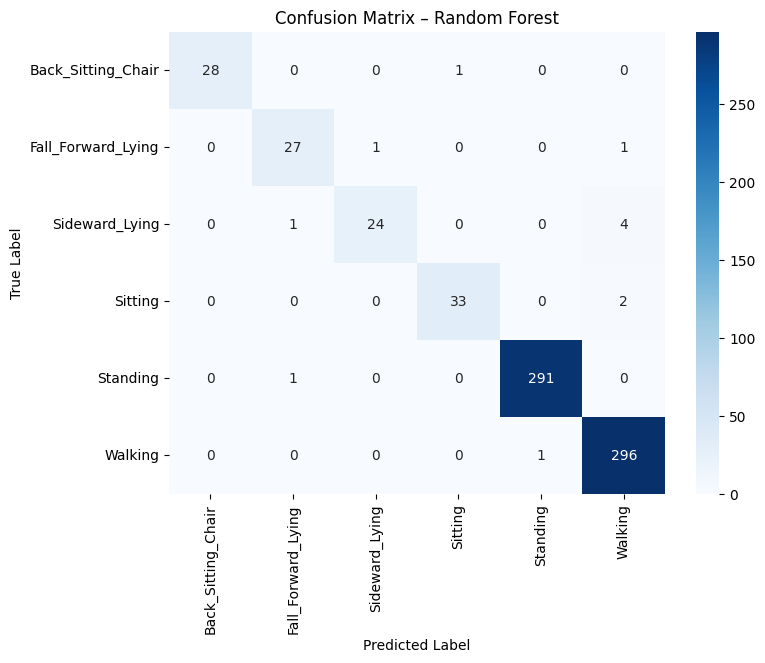

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Random Forest")
plt.show()



## Per-Class Precision, Recall, F1-Score

In [10]:
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(
    y_test,
    y_pred,
    target_names=label_encoder.classes_,
    output_dict=True
)

per_class_metrics = pd.DataFrame(report).transpose()
per_class_metrics



,precision,recall,f1-score,support
Back_Sitting_Chair,1.000000,0.965517,0.982456,29.000000
Fall_Forward_Lying,0.931034,0.931034,0.931034,29.000000
Sideward_Lying,0.960000,0.827586,0.888889,29.000000
Sitting,0.970588,0.942857,0.956522,35.000000
Standing,0.996575,0.996575,0.996575,292.000000
Walking,0.976898,0.996633,0.986667,297.000000
accuracy,0.983122,0.983122,0.983122,0.983122
macro avg,0.972516,0.943367,0.957024,711.000000
weighted avg,0.983051,0.983122,0.982823,711.000000
